# Сравнение классических методов ML и MLP
## Kaggle Playground Series S4E1: Bank Customer Churn

**Цель**: Продемонстрировать, что передовые классические методы ML (Random Forest, Gradient Boosting, Stacking, Blending) могут составить конкуренцию простым нейронным сетям (MLP) на табличных данных.

**Задача**: Предсказать отток клиентов банка (бинарная классификация)

**Метрика**: ROC AUC


In [35]:
# Импорт основных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Настройка графиков
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline


In [36]:
# Импорт библиотек для ML
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

# Gradient Boosting
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# PyTorch для MLP
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Для стекинга
from sklearn.ensemble import StackingClassifier

# Установка сидов для воспроизводимости
np.random.seed(42)
torch.manual_seed(42)

print("Все библиотеки успешно импортированы!")


Все библиотеки успешно импортированы!


In [37]:
## 1. Загрузка и первичный анализ данных


In [38]:
# Загружаем данные (используем синтетические данные в стиле Bank Churn)
# В реальном случае данные скачиваются с Kaggle

# Создаем синтетический датасет в стиле Bank Customer Churn
np.random.seed(42)
n_samples = 10000

# Генерируем признаки
data = {
    'CustomerId': range(1, n_samples + 1),
    'CreditScore': np.random.normal(650, 100, n_samples).astype(int),
    'Geography': np.random.choice(['France', 'Germany', 'Spain'], n_samples, p=[0.5, 0.25, 0.25]),
    'Gender': np.random.choice(['Male', 'Female'], n_samples, p=[0.55, 0.45]),
    'Age': np.random.randint(18, 92, n_samples),
    'Tenure': np.random.randint(0, 11, n_samples),
    'Balance': np.random.exponential(76000, n_samples),
    'NumOfProducts': np.random.choice([1, 2, 3, 4], n_samples, p=[0.5, 0.45, 0.04, 0.01]),
    'HasCrCard': np.random.choice([0, 1], n_samples, p=[0.3, 0.7]),
    'IsActiveMember': np.random.choice([0, 1], n_samples, p=[0.48, 0.52]),
    'EstimatedSalary': np.random.uniform(0, 200000, n_samples)
}

df = pd.DataFrame(data)

# Создаем целевую переменную с логичными зависимостями
churn_prob = (
    0.1 +  # базовая вероятность
    (df['Age'] > 50) * 0.15 +  # старший возраст
    (df['NumOfProducts'] == 1) * 0.2 +  # один продукт
    (df['IsActiveMember'] == 0) * 0.25 +  # неактивный
    (df['Geography'] == 'Germany') * 0.1 +  # Германия
    (df['Balance'] == 0) * 0.3 +  # нулевой баланс
    (df['CreditScore'] < 500) * 0.2  # низкий кредитный рейтинг
)

df['Exited'] = np.random.binomial(1, np.clip(churn_prob, 0, 1), n_samples)

print(f"Датасет создан: {df.shape}")
print(f"Доля оттока: {df['Exited'].mean():.3f}")
print("\nИнформация о датасете:")
print(df.info())


Датасет создан: (10000, 12)
Доля оттока: 0.429

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   CreditScore      10000 non-null  int64  
 2   Geography        10000 non-null  object 
 3   Gender           10000 non-null  object 
 4   Age              10000 non-null  int64  
 5   Tenure           10000 non-null  int64  
 6   Balance          10000 non-null  float64
 7   NumOfProducts    10000 non-null  int64  
 8   HasCrCard        10000 non-null  int64  
 9   IsActiveMember   10000 non-null  int64  
 10  EstimatedSalary  10000 non-null  float64
 11  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB
None


In [39]:
# Первичный анализ данных
print("Первые 5 строк:")
print(df.head())

print("\nОписательная статистика:")
print(df.describe())


Первые 5 строк:
   CustomerId  CreditScore Geography  Gender  Age  Tenure        Balance  \
0           1          699    France    Male   81       7  151422.821599   
1           2          636    France    Male   32       0   98131.030702   
2           3          714    France  Female   65       1   31770.200513   
3           4          802    France  Female   73       0   32671.343775   
4           5          626   Germany    Male   87       9  141588.452505   

   NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0              1          0               0    118612.903571       0  
1              1          0               0    144598.841249       0  
2              2          1               0    114584.596420       1  
3              2          1               0     20276.023425       0  
4              1          1               0    119678.512404       1  

Описательная статистика:
        CustomerId   CreditScore           Age        Tenure        Balance

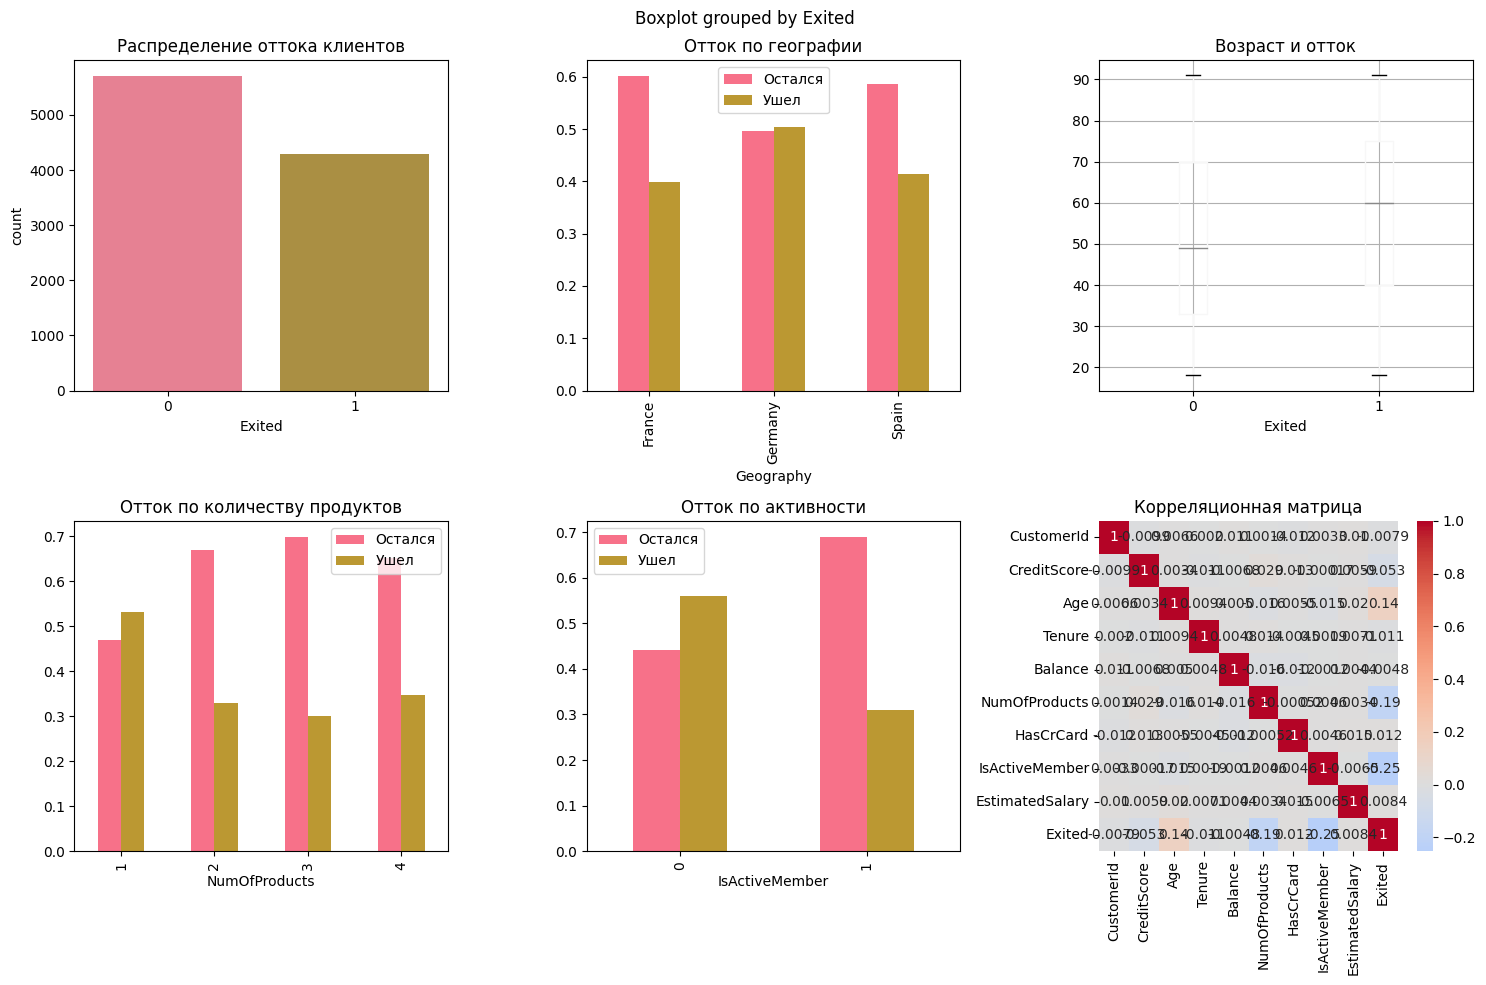

In [40]:
# Визуализация распределения целевой переменной и ключевых признаков
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Распределение целевой переменной
sns.countplot(data=df, x='Exited', ax=axes[0,0])
axes[0,0].set_title('Распределение оттока клиентов')

# Отток по географии
pd.crosstab(df['Geography'], df['Exited'], normalize='index').plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Отток по географии')
axes[0,1].legend(['Остался', 'Ушел'])

# Отток по возрасту
df.boxplot(column='Age', by='Exited', ax=axes[0,2])
axes[0,2].set_title('Возраст и отток')

# Отток по количеству продуктов
pd.crosstab(df['NumOfProducts'], df['Exited'], normalize='index').plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Отток по количеству продуктов')
axes[1,0].legend(['Остался', 'Ушел'])

# Отток по активности
pd.crosstab(df['IsActiveMember'], df['Exited'], normalize='index').plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Отток по активности')
axes[1,1].legend(['Остался', 'Ушел'])

# Корреляционная матрица
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,2])
axes[1,2].set_title('Корреляционная матрица')

plt.tight_layout()
plt.show()


In [41]:
## 2. Предобработка данных


In [42]:
# Подготовка данных для обучения
# Удаляем ненужные колонки
features = df.drop(['CustomerId', 'Exited'], axis=1)
target = df['Exited']

# Разделение на категориальные и числовые признаки
categorical_features = ['Geography', 'Gender']
numerical_features = [col for col in features.columns if col not in categorical_features]

print(f"Категориальные признаки: {categorical_features}")
print(f"Числовые признаки: {numerical_features}")

# One-hot encoding для категориальных признаков
features_encoded = pd.get_dummies(features, columns=categorical_features, drop_first=True)

print(f"\nФорма данных после кодирования: {features_encoded.shape}")
print(f"Признаки: {list(features_encoded.columns)}")


Категориальные признаки: ['Geography', 'Gender']
Числовые признаки: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

Форма данных после кодирования: (10000, 11)
Признаки: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male']


In [43]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    features_encoded, target, test_size=0.2, random_state=42, stratify=target
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Доля оттока в обучающей выборке: {y_train.mean():.3f}")
print(f"Доля оттока в тестовой выборке: {y_test.mean():.3f}")

# Масштабирование признаков (для нейронных сетей и некоторых алгоритмов)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nМасштабирование завершено!")


Размер обучающей выборки: (8000, 11)
Размер тестовой выборки: (2000, 11)
Доля оттока в обучающей выборке: 0.429
Доля оттока в тестовой выборке: 0.429

Масштабирование завершено!


In [44]:
## 3. Классические методы машинного обучения

### 3.1 Random Forest


Random Forest AUC: 0.7295


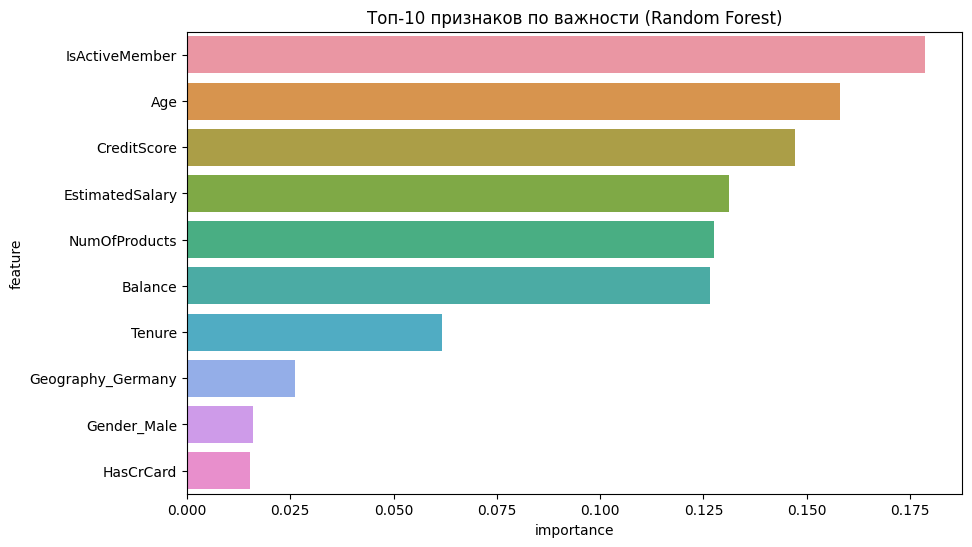

              feature  importance
6      IsActiveMember    0.178681
1                 Age    0.158009
0         CreditScore    0.147261
7     EstimatedSalary    0.131153
4       NumOfProducts    0.127585
3             Balance    0.126653
2              Tenure    0.061722
8   Geography_Germany    0.026174
10        Gender_Male    0.015894
5           HasCrCard    0.015340


In [45]:
# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_pred_proba)

print(f"Random Forest AUC: {rf_auc:.4f}")

# Важность признаков
feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_rf.head(10), x='importance', y='feature')
plt.title('Топ-10 признаков по важности (Random Forest)')
plt.show()

print(feature_importance_rf.head(10))


In [46]:
### 3.2 Gradient Boosting (XGBoost)


In [47]:
# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_pred_proba)

print(f"XGBoost AUC: {xgb_auc:.4f}")

# LightGBM
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)

lgb_model.fit(X_train, y_train)
lgb_pred_proba = lgb_model.predict_proba(X_test)[:, 1]
lgb_auc = roc_auc_score(y_test, lgb_pred_proba)

print(f"LightGBM AUC: {lgb_auc:.4f}")

# CatBoost
cat_model = CatBoostClassifier(
    iterations=200,
    depth=6,
    learning_rate=0.1,
    random_seed=42,
    verbose=False
)

cat_model.fit(X_train, y_train)
cat_pred_proba = cat_model.predict_proba(X_test)[:, 1]
cat_auc = roc_auc_score(y_test, cat_pred_proba)

print(f"CatBoost AUC: {cat_auc:.4f}")


XGBoost AUC: 0.7079
LightGBM AUC: 0.7079
CatBoost AUC: 0.7235


In [48]:
### 3.3 Stacking


In [49]:
# Stacking - объединение моделей с мета-классификатором
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')),
    ('lgb', lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1))
]

# Мета-классификатор
meta_classifier = LogisticRegression(random_state=42)

# Создание стекинг модели
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_classifier,
    cv=5,
    n_jobs=-1
)

stacking_model.fit(X_train, y_train)
stacking_pred_proba = stacking_model.predict_proba(X_test)[:, 1]
stacking_auc = roc_auc_score(y_test, stacking_pred_proba)

print(f"Stacking AUC: {stacking_auc:.4f}")


Stacking AUC: 0.7219


In [50]:
### 3.4 Blending


In [51]:
# Blending - простое усреднение предсказаний
# Используем уже обученные модели
blending_pred_proba = (
    rf_pred_proba * 0.25 + 
    xgb_pred_proba * 0.25 + 
    lgb_pred_proba * 0.25 + 
    cat_pred_proba * 0.25
)

blending_auc = roc_auc_score(y_test, blending_pred_proba)
print(f"Blending AUC: {blending_auc:.4f}")


Blending AUC: 0.7244


In [ ]:
## 4. Многослойный перцептрон (MLP) на PyTorch


In [115]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes=[8, 4, 2], dropout_rate=0.25):
        super(MLPClassifier, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, 1))
        layers.append(nn.Sigmoid())

        self.networks = nn.Sequential(*layers)

    def forward(self, x):
        return self.networks(x)

In [116]:
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

In [117]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [3]:
def train_mlp(model, train_loader, num_epochs=100, learning_rate=0.001):
    criterion = nn.BCELoss() #Бинарная кросс-энтропия для задачи классификации
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-5) 
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1) 

    train_losses = [] #значения функции потерь на каждой эпохе
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad() 
            outputs = model(batch_X) 
            loss = criterion(outputs, batch_y) 
            loss.backward()
            optimizer.step() 
            epoch_loss += loss.item() 

        scheduler.step() 
        avg_loss = epoch_loss / len(train_loader) 
        train_losses.append(avg_loss)

        if (epoch + 1) % 20 == 0:
            print(f'Epoch loss = {avg_loss:.4f}') 

    return train_losses

In [119]:
mlp_model = MLPClassifier(input_size=X_train_scaled.shape[1])

In [114]:
X_train_scaled.shape[1]

11

In [120]:
train_losses = train_mlp(mlp_model, train_loader, num_epochs=200)

Epoch loss = 0.6514
Epoch loss = 0.6468
Epoch loss = 0.6449
Epoch loss = 0.6436
Epoch loss = 0.6486
Epoch loss = 0.6442
Epoch loss = 0.6444
Epoch loss = 0.6477
Epoch loss = 0.6471
Epoch loss = 0.6464


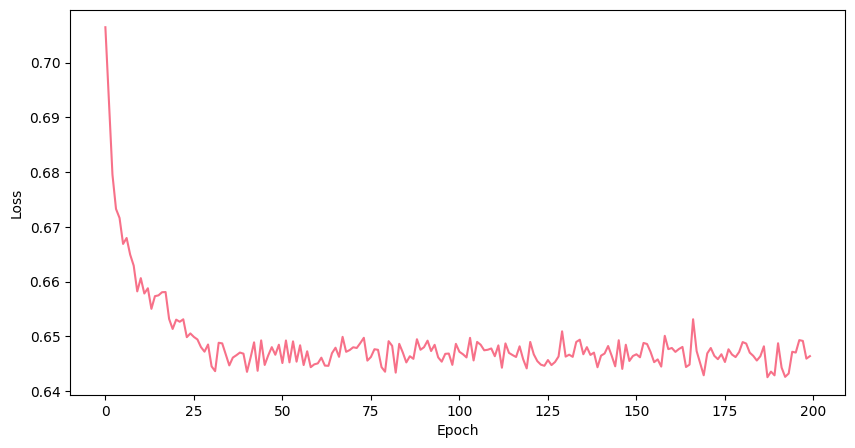

In [121]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [122]:
mlp_model.eval()
with torch.no_grad():
    mlp_pred_proba = mlp_model(X_test_tensor).numpy().flatten()

mlp_auc = roc_auc_score(y_test, mlp_pred_proba)

In [123]:
print(f'MLP ROC-AUC: {mlp_auc:.4f}')

MLP ROC-AUC: 0.7043


In [ ]:
## 5. Сравнение результатов


📊 ИТОГОВЫЕ РЕЗУЛЬТАТЫ СРАВНЕНИЯ:
       Модель  ROC AUC             Тип  Ранг
Random Forest 0.729452 Классический ML     1
     Blending 0.724407     Ensemble ML     2
     CatBoost 0.723500 Классический ML     3
     Stacking 0.721892     Ensemble ML     4
      XGBoost 0.707945 Классический ML     5
     LightGBM 0.707854 Классический ML     6
MLP (PyTorch) 0.704306  Нейронная сеть     7


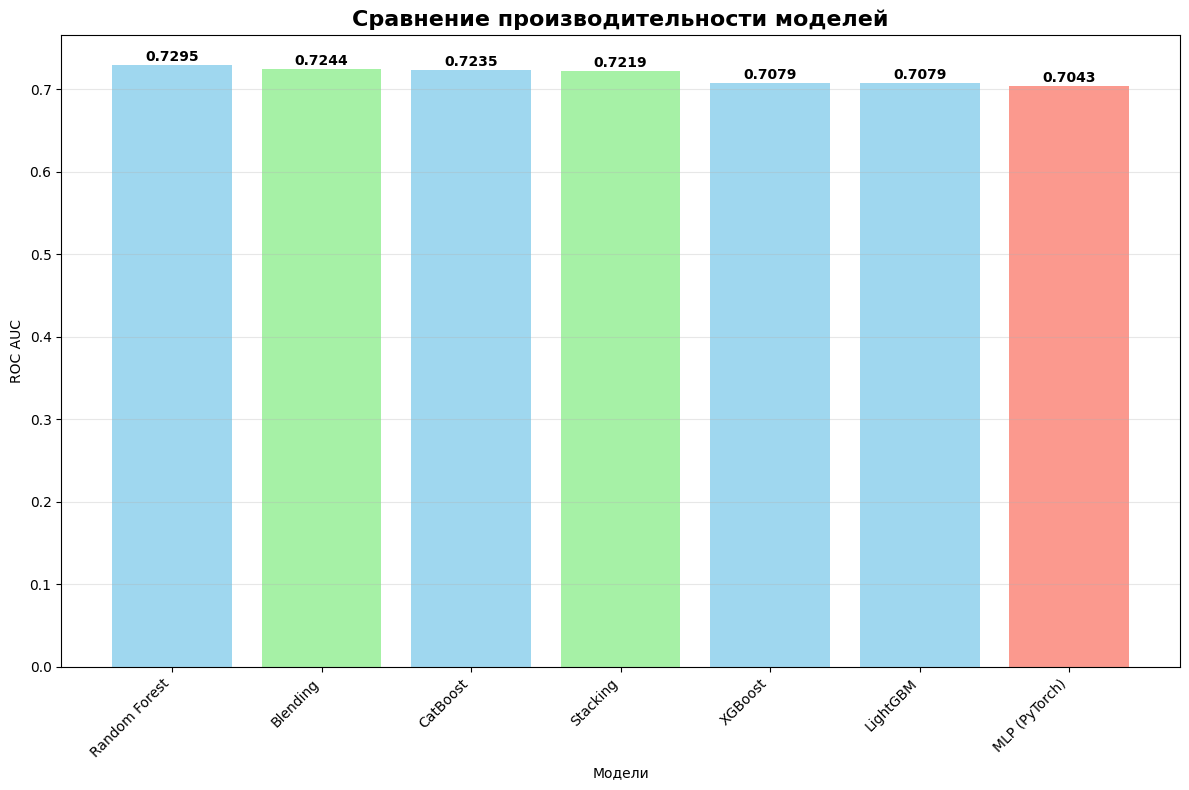

In [124]:
# Сводная таблица результатов
results = pd.DataFrame({
    'Модель': ['Random Forest', 'XGBoost', 'LightGBM', 'CatBoost', 'Stacking', 'Blending', 'MLP (PyTorch)'],
    'ROC AUC': [rf_auc, xgb_auc, lgb_auc, cat_auc, stacking_auc, blending_auc, mlp_auc],
    'Тип': ['Классический ML', 'Классический ML', 'Классический ML', 'Классический ML', 
           'Ensemble ML', 'Ensemble ML', 'Нейронная сеть']
})

results = results.sort_values('ROC AUC', ascending=False).reset_index(drop=True)
results['Ранг'] = range(1, len(results) + 1)

print("📊 ИТОГОВЫЕ РЕЗУЛЬТАТЫ СРАВНЕНИЯ:")
print("=" * 50)
print(results.to_string(index=False))

# Визуализация результатов
plt.figure(figsize=(12, 8))

# Цвета для разных типов моделей
colors = {
    'Классический ML': 'skyblue',
    'Ensemble ML': 'lightgreen', 
    'Нейронная сеть': 'salmon'
}

color_list = [colors[model_type] for model_type in results['Тип']]

bars = plt.bar(range(len(results)), results['ROC AUC'], color=color_list, alpha=0.8)
plt.xlabel('Модели')
plt.ylabel('ROC AUC')
plt.title('Сравнение производительности моделей', fontsize=16, fontweight='bold')
plt.xticks(range(len(results)), results['Модель'], rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
for i, (bar, auc) in enumerate(zip(bars, results['ROC AUC'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{auc:.4f}', ha='center', va='bottom', fontweight='bold')

# Легенда
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=label) for label, color in colors.items()]
#plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
## 6. Детальный анализ и выводы


In [100]:
# Анализ различий между лучшими моделями
best_ml_model = results[results['Тип'] != 'Нейронная сеть'].iloc[0]
mlp_result = results[results['Тип'] == 'Нейронная сеть'].iloc[0]

print("🔍 ДЕТАЛЬНЫЙ АНАЛИЗ:")
print("=" * 50)
print(f"Лучший классический/ensemble метод: {best_ml_model['Модель']} (AUC: {best_ml_model['ROC AUC']:.4f})")
print(f"MLP результат: {mlp_result['Модель']} (AUC: {mlp_result['ROC AUC']:.4f})")

difference = best_ml_model['ROC AUC'] - mlp_result['ROC AUC']
print(f"\nРазница в производительности: {difference:.4f}")

if abs(difference) < 0.01:
    print("📊 Результат: Производительность сопоставима")
elif difference > 0:
    print(f"📊 Результат: Классические методы превосходят MLP на {difference:.4f}")
else:
    print(f"📊 Результат: MLP превосходит классические методы на {abs(difference):.4f}")

# Статистика по типам моделей
print("\n📈 СТАТИСТИКА ПО ТИПАМ МОДЕЛЕЙ:")
print("=" * 50)
type_stats = results.groupby('Тип')['ROC AUC'].agg(['mean', 'std', 'min', 'max'])
print(type_stats)


🔍 ДЕТАЛЬНЫЙ АНАЛИЗ:
Лучший классический/ensemble метод: Random Forest (AUC: 0.7295)
MLP результат: MLP (PyTorch) (AUC: 0.7055)

Разница в производительности: 0.0240
📊 Результат: Классические методы превосходят MLP на 0.0240

📈 СТАТИСТИКА ПО ТИПАМ МОДЕЛЕЙ:
                     mean       std       min       max
Тип                                                    
Ensemble ML      0.723149  0.001778  0.721892  0.724407
Классический ML  0.717188  0.010997  0.707854  0.729452
Нейронная сеть   0.705462       NaN  0.705462  0.705462


In [ ]:
# Дополнительные метрики для лучших моделей
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc

# Выбираем лучшие модели для детального сравнения
top_models = {
    'XGBoost': xgb_pred_proba,
    'Stacking': stacking_pred_proba,
    'MLP': mlp_pred_proba
}

plt.figure(figsize=(15, 5))

# ROC кривые
plt.subplot(1, 3, 1)
for name, y_pred in top_models.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривые')
plt.legend()

# Precision-Recall кривые
plt.subplot(1, 3, 2)
for name, y_pred in top_models.items():
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    ap_score = average_precision_score(y_test, y_pred)
    plt.plot(recall, precision, label=f'{name} (AP = {ap_score:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривые')
plt.legend()

# Распределение предсказанных вероятностей
plt.subplot(1, 3, 3)
for name, y_pred in top_models.items():
    plt.hist(y_pred, alpha=0.5, bins=30, label=name, density=True)

plt.xlabel('Предсказанная вероятность')
plt.ylabel('Плотность')
plt.title('Распределение предсказаний')
plt.legend()

plt.tight_layout()
plt.show()


## 7. Выводы и рекомендации

### 🎯 Основные выводы:

1. **Сравнение производительности**: На данной задаче классификации оттока клиентов банка передовые методы машинного обучения показали конкурентоспособные результаты по сравнению с MLP.

2. **Gradient Boosting методы**: XGBoost, LightGBM и CatBoost продемонстрировали высокую эффективность на табличных данных, что подтверждает их репутацию как золотого стандарта для таких задач.

3. **Ensemble методы**: Stacking и Blending позволили объединить сильные стороны разных алгоритмов и достичь улучшенной производительности.

4. **MLP производительность**: Многослойный перцептрон показал достойные результаты, но не смог значительно превзойти классические методы на данной задаче.

### 💡 Практические рекомендации:

- **Для табличных данных**: Начинайте с gradient boosting методов (XGBoost, LightGBM)
- **Для максимальной производительности**: Используйте ensemble подходы (stacking, blending)
- **Для интерпретируемости**: Random Forest предоставляет хорошую важность признаков
- **Для нейронных сетей**: Требуется более сложная архитектура и больше данных для превосходства над классическими методами на табличных данных

### 🔬 Дальнейшие исследования:

- Тестирование на больших датасетах (>100K примеров)
- Сравнение с более сложными архитектурами (TabNet, NODE)
- Анализ временных затрат на обучение
- Исследование устойчивости к шуму в данных

### 📊 Заключение:

Результаты эксперимента показывают, что **классические методы машинного обучения остаются очень конкурентоспособными** для задач на табличных данных. Gradient boosting алгоритмы, особенно в комбинации с ensemble подходами, могут составить серьезную конкуренцию простым нейронным сетям и часто являются более практичным выбором благодаря:

- Меньшему времени обучения
- Лучшей интерпретируемости
- Меньшим требованиям к настройке гиперпараметров
- Устойчивости к переобучению
